# Telling A Story Using Data

Task: You’ve decided to open a small robot-run cafe in Los Angeles. The project is promising but expensive, so you and your partners decide to try to attract investors. They’re interested in the current market conditions—will you be able to maintain your success when the novelty of robot waiters wears off? Your partners have asked you to prepare some market research using open-source data on restaurants in LA.

### Load Data

In [1]:
! pip install -q usaddress

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import usaddress
import re

In [3]:
# load in data file 
data = pd.read_csv('/datasets/rest_data_us.csv', sep=',')

# study general information 
data.info()

display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
id             9651 non-null int64
object_name    9651 non-null object
address        9651 non-null object
chain          9648 non-null object
object_type    9651 non-null object
number         9651 non-null int64
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


### Pre-process the data

In [4]:
# drop duplicates and NAN values
data = data.drop_duplicates()

# rename column names
data.columns = ['id', 'name', 'address', 'chain', 'type', 'total_seats']

# chain column - drop rows with NA values
data['chain'].dropna(inplace=True)

# name column - replace NaN and standardize names 

# drop name colums with empty strings
data.replace("", float("NaN"), inplace=True)
data.dropna(subset = ["name"], inplace=True)

# method to clean names
def cleanNames(name):
    name = name

    # if # symbol in name, split it to remove numbers
    if '#' in name:
        name = name.split('#')[0].strip()
    
    # if - symbol in name, split it to remove numbers
    if '-' in name:
        tmp = name.split('-')

        if tmp[1].isdecimal():
            name = tmp[0].strip()
    
    return name
    
# clean names to remove branch numbers
data['name'] = data.name.apply(cleanNames)

# method to clean addresses
def cleanAddress(address):
    address = address

    # hardcode singular cases
    if address.startswith('OLVERA'):
        address = 'OLVERA,Los Angeles,USA'
    elif address.startswith('1033 1/2 LOS ANGELES ST'):
        address = '1033 1/2 LOS ANGELES ST,Los Angeles, USA'
        
    # standard cases
    else:
        raw = usaddress.parse(address)
        addressDict = {}
        for i in raw:
            addressDict.update({i[1]:i[0]})
        
        if 'StreetNamePostType' in addressDict:
            address = addressDict['AddressNumber'] + " " + str(addressDict['StreetName']) + \
                " " + str(addressDict['StreetNamePostType'])+str(',Los Angeles,USA')
        else:
            address = addressDict['AddressNumber'] + " " + str(addressDict['StreetName']) + \
                " "+str(',Los Angeles,USA')
    
    return address
    
# clean names to remove branch numbers
data['address'] = data.address.apply(cleanAddress)

### Investigate the proportions of the various types of establishments. 

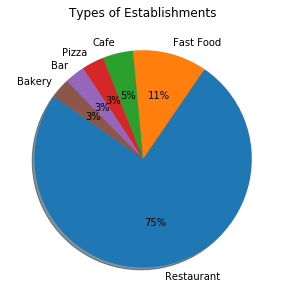

In [5]:
# transform value_counts for type of establishment to dataframe
typeData = data['type'].value_counts().rename_axis('type').reset_index(name='count')

# plot pie chart with proportions
plt.figure(figsize=(10, 5))
plt.pie(typeData['count'], labels=typeData['type'],autopct='%0.f%%', shadow=True, startangle=145)
plt.title('Types of Establishments')
plt.show()

The breakdown of the various types of establishments can be seen in the pie chart above: 75% of establishments are restaurants, 11% of establishments are fast food, and the rest are broken down between cafe, pizza, bar and bakery.

### Investigate the proportions of chain and nonchain establishments.

Text(0.5, 1.0, 'Chain vs Non-Chain Establishments')

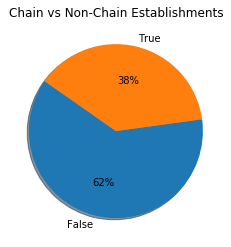

In [6]:
# transform value_counts for chain establishment to dataframe
chainData = data['chain'].value_counts().rename_axis('chain').reset_index(name='count')

# plot pie chart with proportions
plt.pie(chainData['count'], labels=chainData['chain'],autopct='%0.f%%', shadow=True, startangle=145)
plt.title('Chain vs Non-Chain Establishments')

The breakdown between chain and nonchain establishments can be seen in the pie chart above. More than half (62%) of the establishments are nonchain estabilshments, while 38% of the establishments belong to a chain. 

### Which type of establishment is typically a chain?

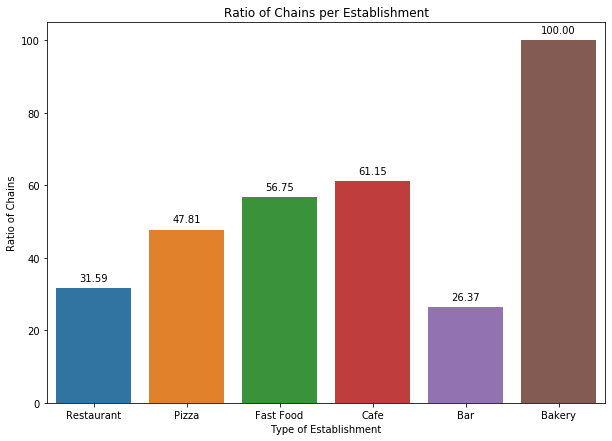

In [7]:
# pull out data from only chains
typeChainData = data[data['chain'] == True]

# count the number of types of establishments
typeChainData = pd.pivot_table(typeChainData,index=['chain','type'], values=['id'], aggfunc='count').reset_index()
typeChainData.columns = ['chain', 'type', 'count']
typeChainData = typeChainData.sort_values(by='count', ascending=False)

# extract total number of establishments
totalData = data['type'].value_counts().rename_axis('type').reset_index(name='total')

# combine data frames
typeChainData = pd.merge(typeChainData, totalData, how='inner', on='type')
typeChainData['ratio'] = typeChainData['count'] / typeChainData['total'] * 100

# plot bar graph
plt.figure(figsize=(10, 7))

ax = sns.barplot(data = typeChainData.sort_values('type', ascending=False), 
                 x='type', 
                 y='ratio')

# Add titles and captions
plt.xlabel('Type of Establishment')
plt.ylabel('Ratio of Chains')
plt.title('Ratio of Chains per Establishment')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')


plt.show()

The breakdown of which types of establishments are typically chains can be seen in the bar chart above. As it shows, all bakeries are part of a chain, more than half of cafes and fast food establishments are chains and less than half of pizza places, restaurants and bars are chains. 

### What characterizes chains: many establishments with a small number of seats or a few establishments with a lot of seats?

Text(0.5, 1.0, 'Correlation between # of seats and # of establishments')

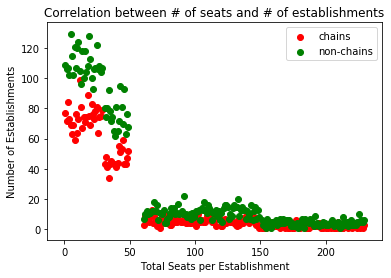

In [8]:
# extract data from only chains, sort by count
chainData = data[data['chain'] == True]
chainData = pd.pivot_table(chainData, index=['total_seats'], values=['id'], aggfunc=['count']).reset_index()
chainData.columns = ['total_seats','count']
chainData = chainData.sort_values(by='count', ascending=False)

# extract data from only nonchains, sort by count
nonChainData = data[data['chain'] == False]
nonChainData = pd.pivot_table(nonChainData, index=['total_seats'], values=['id'], aggfunc=['count']).reset_index()
nonChainData.columns = ['total_seats','count']
nonChainData = nonChainData.sort_values(by='count', ascending=False)

# plot scatter plot
plt.scatter(chainData['total_seats'], chainData['count'], color='r', label='chains')
plt.scatter(nonChainData['total_seats'], nonChainData['count'], color='g', label='non-chains')
plt.xlabel('Total Seats per Establishment')
plt.ylabel('Number of Establishments')
plt.legend()
plt.title('Correlation between # of seats and # of establishments')

The scatter plot above shows the correlation between the number of seats and the number of establishments. In general, most of the establishments have 50 or less seats, while less of the establishments have 50 or more seats. However, the nonchain establishments typically have more seats than the chain establishments. This can be seen in both the areas: more nonchain restaurants than chain restaurants have less than 50 seats and more nonchain restaurants than chain restaurants have more than 50 seats. Chains seem to be characterized by many establishments with a small number of seats.

### Determine the average number of seats for each type of establishment. On average, which type of establishment has the greatest number of seats? 

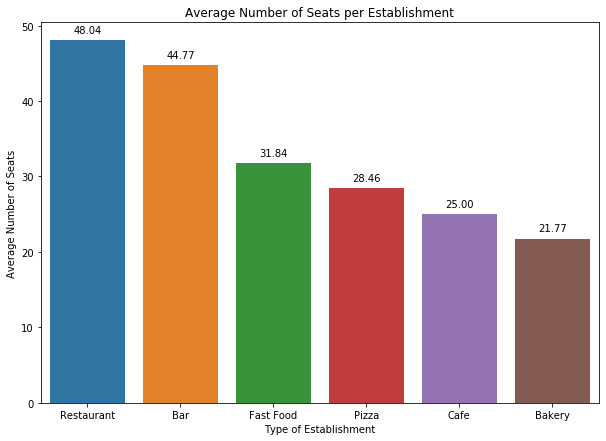

In [9]:
# bar graph labels and values
labels = ['Cafe', 'Restaurant', 'Fast Food', 'Pizza', 'Bar', 'Bakery']    
values = []

# for each establishment, extract data, calculate avg and append to list
for establishment in range(len(labels)):
    estType = labels[establishment]
    currData = data[data['type'] == estType]
    avgSeats = currData['total_seats'].mean()
    values.append(avgSeats)

# create df from labels and values
df = pd.DataFrame({"Establishment":labels, "Seats":values})

plt.figure(figsize=(10, 7))

# Plot barplot
ax = sns.barplot(data = df.sort_values('Seats', ascending=False), 
                 x='Establishment', 
                 y='Seats')

# Add titles and captions
plt.xlabel('Type of Establishment')
plt.ylabel('Average Number of Seats')
plt.title('Average Number of Seats per Establishment')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')


plt.show()

The bar graph above shows the average number of seats for each type of establishment. On average, restaurants have the greatest amount of seats (almost 50 seats!).

### Put the data on street names from the address column in a separate column.

In [10]:
# method to extract only street name
def streetNames(street):
    street = street.split(',')[0].split(' ')[-2:]
    street = " ".join(street)
    if street == '103 ':
        street = '103RD ST'
    return street
    
# extract only street names
data['street'] = data.address.apply(streetNames)
display(data)

,id,name,address,chain,type,total_seats,street
0,11786,HABITAT COFFEE SHOP,"3708 ROCK BLVD,Los Angeles,USA",False,Cafe,26,ROCK BLVD
1,11787,REILLY'S,"100 WORLD WAY,Los Angeles,USA",False,Restaurant,9,WORLD WAY
2,11788,STREET CHURROS,"6801 HOLLYWOOD BLVD,Los Angeles,USA",False,Fast Food,20,HOLLYWOOD BLVD
3,11789,TRINITI ECHO PARK,"1814 SUNSET BLVD,Los Angeles,USA",False,Restaurant,22,SUNSET BLVD
4,11790,POLLEN,"2100 PARK AVE,Los Angeles,USA",False,Restaurant,20,PARK AVE
...,...,...,...,...,...,...,...
9646,21432,HALL OF JUSTICE,"217 TEMPLE AVE,Los Angeles,USA",False,Restaurant,122,TEMPLE AVE
9647,21433,FIN-MELROSE,"5750 MELROSE AVE,Los Angeles,USA",False,Restaurant,93,MELROSE AVE
9648,21434,JUICY WINGZ,"6741 HOLLYWOOD BLVD,Los Angeles,USA",True,Fast Food,15,HOLLYWOOD BLVD
9649,21435,MEDIDATE COFFEE,"548 SPRING ST,Los Angeles,USA",False,Cafe,6,SPRING ST


### Plot a graph of the top ten streets by number of establishments.

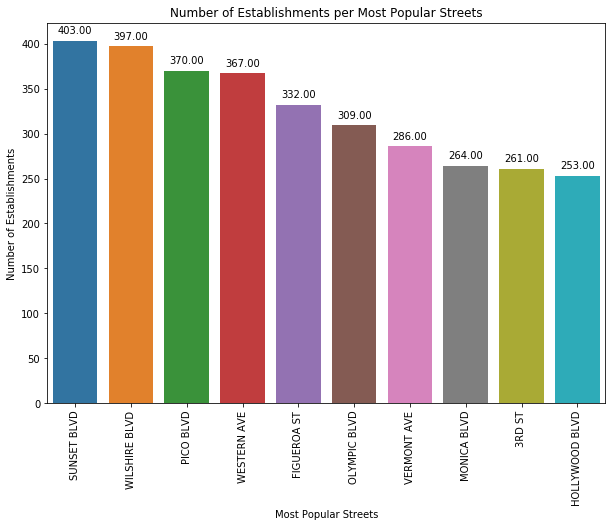

In [11]:
# sort street data by number of occurrences
streetData = pd.pivot_table(data, index=['street'], values=['id'], aggfunc=['count']).reset_index()
streetData.columns = ['street','count']
topStreetData = streetData.sort_values(by='count', ascending=False).head(10)

# Plot barplot
plt.figure(figsize=(10, 7))

ax = sns.barplot(data = topStreetData.sort_values('count', ascending=False), 
                 x='street', 
                 y='count')

# Add titles and captions
plt.xlabel('Most Popular Streets')
plt.ylabel('Number of Establishments')
plt.title('Number of Establishments per Most Popular Streets')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

The bar chart above shows the top ten streets by the number of establishments located on the street. The most popular streets for establishments are Sunset Boulevard, Wilshire Boulevard, Pico Boulevard and Western Avenue.

### Find the number of streets that only have one restaurant.

In [12]:
# extract streets with a single restaurant
singleStreetData = streetData[streetData['count'] == 1]
numStreets = len(singleStreetData)
print('There are ' + str(numStreets) + " with only one restaurant on them.")

There are 237 with only one restaurant on them.


### For streets with a lot of establishments, look at the distribution of the number of seats. What trends can you see?

Text(0, 0.5, 'Density of Streets')

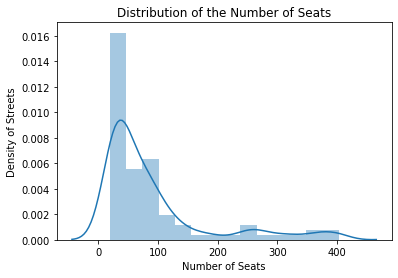

In [13]:
# calculate avg number of restaurants per street, extract only those greater than avg
avgNumRestaurants = streetData['count'].mean().round()
avgStreetData = streetData[streetData['count'] > avgNumRestaurants]

# plot distribution plot
ax = sns.distplot(avgStreetData['count'])
ax.set_title('Distribution of the Number of Seats')
ax.set_xlabel('Number of Seats')
ax.set_ylabel('Density of Streets')

For streets with a lot of establishments (greater than the average number of establishments per street), most of those establishments have 100 or less seats. In fact, it seems that many of those establishments have less than 50 seats.

### Draw an overall conclusion and provide recommendations on restaurant type and number of seats.

I’ve decided to open a small robot-run cafe in Los Angeles. The project is promising but expensive, so my partners and I decided to try to attract investors. The investors are interested in the current market conditions in order to determine if we will be able to maintain your success when the novelty of robot waiters wears off.

After an analysis of current food establishment market in Los Angeles, there are several conclusions that can be made regarding the data. The most popular establishments in the LA area are restaurants, as over 75% of food estalishments are restaurants. Certain types of establishments are largely part of a chain: over 50% of bakeries, cafes and fast food places are part of a chain while less than 50% of restaurants and bars are part of a chain. Chains are characterized by having many establishments with a small number of seats (less than 100 seats). The average number of seats in a restaurant are 48 seats, in a bar are 45 seats and less than those 30 seats for other food establishments. The streets in LA with the most food establishments on them (more than 250 food establishments) are: Sunset Boulevard, Wilshire Boulevard, Pico Boulevard, Western Avenue, Figueroa Street, Olympic Boulevard, Vermount Avenue, Monica Boulevard, 3rd Street and Holly Boulevard. The establishments that are on these most popular streets have mostly anywhere between 20-100 seats. 

In conclusion, I believe that the most profitable and worthwhile food establishment to invest in would be either a restaurant or a bar with anywhere between 40-50 seats that is located on any one of those 10 most popular streets mentioned above. 

### Presentation

Presentation: https://docs.google.com/presentation/d/13u_eESHplwkC08BbgmP4BWCgLL9kzzZLzwcAFci5O7E/edit?usp=sharing